In [ ]:
"""
    Convolving the already cleaned color maps to make them look even prettier.

"""

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
from astropy.wcs import WCS
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

from dictionaryThings import loadDict
from ObsInfo import ObsInfo

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
out = 'modOut1'
arcsec = '1arc'
topDir = '/Volumes/QbertPrimary/umdResearch/adapProposalNearby/'


# ----------------------------------------- #
# Necessary parameter file and dictionaries #
# ----------------------------------------- #
# Dictionary of galaxy properties
objDictName = topDir + 'objectInfoDict.pkl'
# Dictionary of emission line properties.
lineDict = loadDict(topDir + 'emiLineDict.pkl')
# Text file of line fitting parameters.
paramFileName = topDir + 'fittingParametersV4.txt'


# -------------------------------------------------- #
# Read in the parameter file containing line profile #
# velocity limits and continuum fitting information. #
# -------------------------------------------------- #
paramFileData = np.genfromtxt(paramFileName, dtype = None, 
                              autostrip = True, names = True, encoding=None)


for x in range(len(paramFileData)):
    # ------------------------------------ #
    # Get the galaxy and line information. #
    # ------------------------------------ #
    obsInfo = ObsInfo(x, paramFileName, objDictName)
    
    # Name of the emission line.
    lineName = paramFileData['lineNameShort'][x]
    # Rest wavelength of the emission line.
    restWave = lineDict[lineName]['restWave']


    # ----------------------------------------- #
    # Create the base names for saving outputs. #
    # ----------------------------------------- #
    # Base for the object's file names.
    objectNameBase = (str(obsInfo.obsId)+'_'+obsInfo.objectName
                      +'_'+lineName)
    
    # Base path to the object's folders.
    objectPathBase = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName
                          +'/'+arcsec+'/3dBarolo/')
    if (not os.path.exists(objectPathBase)):os.makedirs(objectPathBase)


    fitsFile = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                +arcsec+'/outFitsFiles2/'+objectNameBase+'_cleaned.fits')
    fitsHdu = fits.open(fitsFile)
    data = fitsHdu['contSubFluxesClean'].data
    trueMask = np.ma.getmask(np.ma.masked_where(data==0,data)) 
    dataMasked = np.ma.masked_array(fitsHdu['contSubFluxesClean'].data,mask=trueMask)
    dataModMasked = np.ma.masked_array(fitsHdu['modelFluxesClean'].data,mask=trueMask)
    dataFluxesMasked = np.ma.masked_array(fitsHdu['fluxClean'].data,mask=trueMask[100,:,:])
    dataV50Masked = np.ma.masked_array(fitsHdu['v50Clean'].data,mask=trueMask[100,:,:])
    dataW1Masked = np.ma.masked_array(fitsHdu['w1Clean'].data,mask=trueMask[100,:,:])        
    dataW2Masked = np.ma.masked_array(fitsHdu['w2Clean'].data,mask=trueMask[100,:,:])

    vels = fitsHdu['zCorrVels'].data
    pacsWcs=WCS(fitsHdu['image'].header).celestial
    nRows,nCols,nFluxes = data.shape[2], data.shape[1], data.shape[0]
    minProfIdx = (np.abs(vels - (obsInfo.profileMin))).argmin()
    maxProfIdx = (np.abs(vels - (obsInfo.profileMax))).argmin()
    
    print obsInfo.objectName, lineName
    break

ngc1068 oiii88


In [4]:
    # Sigma value for the 2D kernel.
    sig=2/2.35
    kernel = Gaussian2DKernel(sig)
    # Do the convolution in both flux units (unless the line is CII)
    conImg=convolve(dataFluxesMasked,kernel)
    
    conImgMasked = np.ma.masked_array(conImg,mask=trueMask[100,:,:])

Unknown coordinate system, RA---TAN, DEC--TAN, equinox=nan


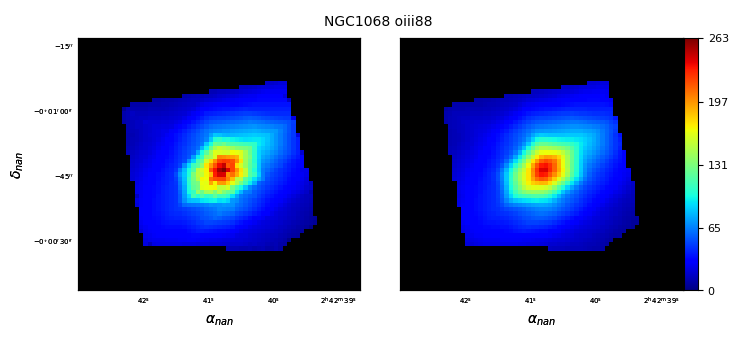

In [10]:
    import pywcsgrid2
    from mpl_toolkits.axes_grid1.axes_grid import AxesGrid

    
    imgList = [dataFluxesMasked,conImgMasked]

    vmin = np.nanmin(np.concatenate((dataFluxesMasked,conImgMasked)))
    vmax = np.nanmax(np.concatenate((dataFluxesMasked,conImgMasked)))

    labelSize = 5
    matplotlib.rcParams['xtick.labelsize'] = labelSize
    matplotlib.rcParams['ytick.labelsize'] = labelSize

    cbarMode = 'single'
    cbarPad=0.01
    axesPad = (0.4,0.1)

    # grid helper
    grid_helper = pywcsgrid2.GridHelper(wcs=pacsWcs)
    fig = plt.figure(facecolor='white',dpi=100,figsize=(8,4))
    # Setup the grid for plotting.
    grid = AxesGrid(fig, 111,
                  nrows_ncols=(1,2),
                  axes_pad= axesPad,
                  cbar_mode=cbarMode,
                  cbar_location='right',
                  cbar_pad=cbarPad,
                  axes_class=(pywcsgrid2.Axes, dict(grid_helper=grid_helper)),
                  share_all=True)
    # Plot the image.
    cmap = matplotlib.cm.jet
    cmap.set_bad('black',1.) ## Set masked pixels to be black.

    for count in [0,1]:
        ax = grid[count]
        im = ax.imshow(imgList[count],vmin=vmin,vmax=vmax,cmap=cmap)

    tickLevels=np.linspace(vmin,vmax,5,endpoint=True,dtype=int)
    cbar1 = ax.cax.colorbar(im,ticks=tickLevels)
    cbar1.ax.tick_params(labelsize=8)

    fig.text(0.5, 0.85, obsInfo.objectName.upper() + ' ' + lineName,ha='center',fontsize=10)

    plt.show()

In [ ]:
    # Output FITS files
    fitsSavePath = objectPathBase + 'outFitsFiles2/'
    if (not os.path.exists(fitsSavePath)):os.makedirs(fitsSavePath)


    # Make new FITS file with cleaned images and cubes.
    fitsSaveName = fitsSavePath + objectNameBase + '_cleaned.fits'
    for propName in propDictCopy.keys():
        createHdu(propDictCopy[propName],fitsHdu, propName+'Clean')
    createHdu(vels,fitsHdu, 'zCorrVels')

    # Save HDUList to new FITS file.
    fitsHdu.writeto(fitsSaveName, overwrite=True)